<div class="alert alert-info">
    <h1>Imports</h1>
    </div>

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import tarfile
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score,accuracy_score
import librosa
import librosa.display
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from pytorchtools import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

<div class="alert alert-info">
    <h1>Download the data</h1>
    </div>

In [2]:
# this cell download the zip file, extract it and put all the data in a directory called "data"
if("data.tar.gz" not in os.listdir()):
    ! curl 'https://00e9e64bacba00d8130d6ad65477cc806c70a1924d3a4e8b27-apidata.googleusercontent.com/download/storage/v1/b/download.tensorflow.org/o/data%2Fspeech_commands_v0.02.tar.gz?qk=AD5uMEuaC4FVeOY6PkFT5rygIJ24UwmdquEff3z3q1-dmzRYOHS29cVZy6stFHJ0A7u8S2AAefigfyeGR-SyRBlLtqElkb20fyG9JqQkVrgEheYSK5SSVA_LHUbft5-BTe5wFkJFNyZIsjhZqGaGL3u_1k7k1LNTq1TE0-a1EBqUxl2T88Yzw2bkJqcRtEr1CMLqoclQSki-6MteOpExIxmvUOzB5G6N6aXYZliHbsCa4SlCgjcUa-tN808D6uPdXazZtLfbvgDdxqaKQfCM32HdmFHD75mm0oGgmVwujMZAwFnEka9-OGQHlEPXU3x4zajn9srXQJNq74Va77OIykXo1QI9G_51TFkDzCtcAkqoTUg4a5Dk-cEJZApbiAzrRfiaDNm8gHcFZHCCryJe7SgwATUUNwnXikxTN15m4CapDx2zMn20K1Z24Th5aJkd7qPdkPaXRcD5slMHF_j5Igde1OD4hO-g8A6LpnXZa_4jqsQVysfvUhvPMBkcAIw0pZl5g6iJ2uyo7LXu4Q4YmPetgsJMX00WRsQmuWlzW0ItXzXhhA6LTtW62C-Pz3-8O4DQqZvGAqaM7Ki9JOeRXKQRrWqfyPrKG6QXbKqqhS6G2wMoi0kjNCS5LDiuwjRdutXHuCzI785ORVUtQaFhnn3jCm0KLBrIyD1BPNenCXtWfisT8e3wnidL28_VMpnAp8FNfFMfPEesnqOzx0g_g9ATkPfGUrm3_GV1hDmwn0SLt6n0oQdxQTflEk_j53D1sY1ANEI1lUhQEjdweg7Ik_Qx-s7OFijQwy4NmqHinOAJAYCrACzRvcecpxXBfE57rf05qA2JZr7L' -H 'authority: 00e9e64bacba00d8130d6ad65477cc806c70a1924d3a4e8b27-apidata.googleusercontent.com' -H 'upgrade-insecure-requests: 1' -H 'user-agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36' -H 'accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8' -H 'x-client-data: CIa2yQEIprbJAQipncoBCKijygEIv6fKAQiQqMoBCOKoygEY+aXKAQ==' -H 'referer: https://perso.limsi.fr/barras/parole/' -H 'accept-encoding: gzip, deflate, br' -H 'accept-language: en-US,en;q=0.9' -H 'cookie: NID=146=2m64YwK1FU_-wWYEr0N6qIT8KCPul94SVvGNE1YFUODGL-9ZZYgtf0PjHL_TrgeguaQjrWszdcM8aTlORHFViPx5R3pkEaM2uaQDIPyQkNY-ns5aQ0_77DSWxzvulfHWNxRIonT9b28IBORFdd1Cb8nPngy3F8nCQarRxGO2hNM' --compressed --output data.tar.gz
    tar = tarfile.open("data.tar.gz", "r:gz")
    tar.extractall()
    tar.close()
    if("data" not in os.listdir()):
        ! mkdir data
    for file in os.listdir():
        if(not file.endswith("ipynb") and not file.endswith("tar.gz")):
            shutil.move(file,"data/")

<div class="alert alert-info">
    <h1>Data exploration and preparation</h1>
    </div>

In [3]:
# create a dictionary containing for each label the corresponding number of audio 
main_dir = "data"
noise_dir = "_background_noise_"
dico = {}
for sub in os.listdir(main_dir):
    if(os.path.isdir(os.path.join(main_dir,sub)) and not sub.startswith('.ipynb') and sub != noise_dir):
        dico[sub] = len(os.listdir(os.path.join(main_dir,sub)))

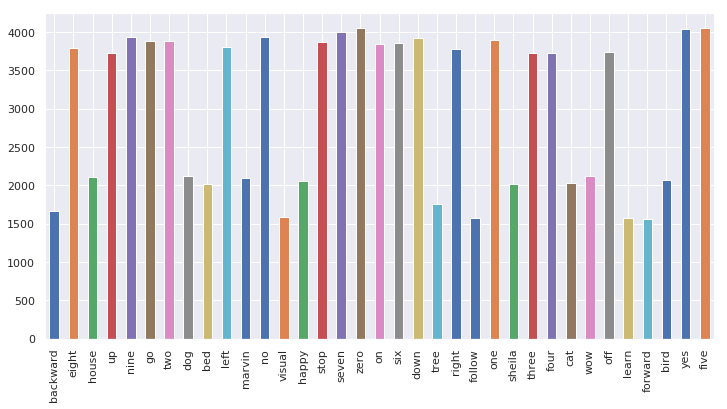

In [4]:
sns.set()
plt.figure(figsize=(12,6))
pd.Series(dico).plot(kind='bar')
plt.show()

In [5]:
# create a list of labels to be the negative class
unknown = ['house','dog','bed','marvin','happy','sheila','tree','wow','cat','bird']

## _Visualize a spectrogram_

In [6]:
y, sr = librosa.load("data/right/012187a4_nohash_0.wav",sr = 16000)

# pad with zeros if necessary
y = np.pad(y, (int(np.ceil((16000 - y.shape[0])/2)),\
               int(np.floor((16000 - y.shape[0])/2))), "constant", constant_values = 0)
print(y.shape)

(16000,)


In [7]:
# shape of a histogram
librosa.feature.melspectrogram(y, sr=16000, n_mels=40, n_fft=400,hop_length=160, power=1).shape

(40, 101)

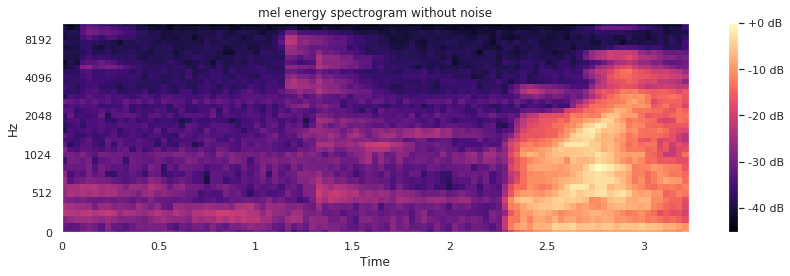

In [8]:
def plot(y, title = ""):
    
    S = librosa.feature.melspectrogram(y, sr=16000, n_mels=40, n_fft=400,hop_length=160, power=1)

    # Convert to log scale (dB). We'll use the peak power (max) as reference.
    log_S = librosa.power_to_db(S, ref=np.max)

    # Make a new figure
    plt.figure(figsize=(12,4))

    # Display the spectrogram on a mel scale
    # sample rate and hop length parameters are used to render the time axis
    librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')

    # Put a descriptive title on the plot
    plt.title(title)

    # draw a color bar
    plt.colorbar(format='%+02.0f dB')

    # Make the figure layout compact
    plt.tight_layout()

plot(y,'mel energy spectrogram without noise')

## _Add some noise_

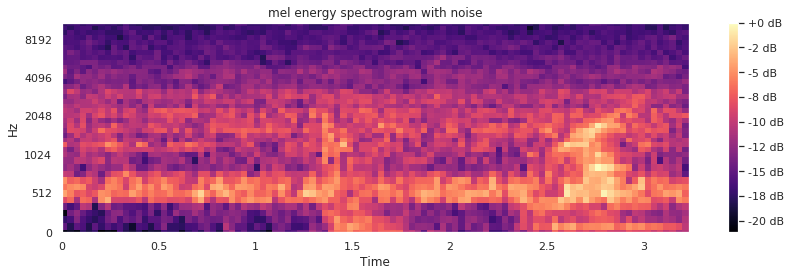

In [9]:
y1, sr = librosa.load("data/right/012187a4_nohash_0.wav",sr = 16000)
# pad with zeros if necessary
y1 = np.pad(y1, (int(np.ceil((16000 - y1.shape[0])/2)),\
               int(np.floor((16000 - y1.shape[0])/2))), "constant", constant_values = 0)

y2 = librosa.load("data/_background_noise_/doing_the_dishes.wav",sr = 16000)[0][2000:18000]

y = (y1+y2)/2

plot(y,'mel energy spectrogram with noise')

## _Prepare training, validation and testing data_

In [10]:
# create lists that contain the path for each audio in training, validation and testing set

with open("data/testing_list.txt","r") as f:
    test_list = f.read().split("\n")

with open("data/validation_list.txt","r") as f:
    val_list = f.read().split("\n")
    
train_list = []
for sub in os.listdir(main_dir):
    if(os.path.isdir(os.path.join(main_dir,sub)) and not sub.startswith('.ipynb') and sub != noise_dir):
        for wav in os.listdir(os.path.join(main_dir,sub)):
            if(os.path.join(sub,wav) not in val_list and os.path.join(sub,wav) not in test_list):
                train_list.append(os.path.join(sub,wav))

print(len(train_list), len(test_list), len(val_list))

84843 11006 9982


In [11]:
# create a list of words that we will used to simplify the problem
wanted_list = ['zero','one','two','three','four','five','six','seven','eight','nine']

In [12]:
# giving a list l, a number of noise data to create nb, and a boolean to precise if the data should be noisy
# return a numpy array of the corresponding spectogram

def prepare(l, nb, noise=False):
    X = []
    y = []
    
    
    noise_wav = os.listdir(os.path.join(main_dir,noise_dir))
    noisy = []
    for wav in noise_wav:
        if(wav.endswith("wav")):
            noisy.append(librosa.load(os.path.join(main_dir,noise_dir,wav),sr=16000)[0])
    noisy = np.hstack(noisy)
    
    for el in l:
        if(el.endswith("wav") and el.split("/")[0] in wanted_list):
            tmp,sr = librosa.load(os.path.join(main_dir,el),sr = 16000)
            tmp = np.pad(tmp, (int(np.ceil((16000 - tmp.shape[0])/2)),int(np.floor((16000 - tmp.shape[0])/2))), "constant", constant_values = 0)
            
            if(noise):
                rand = np.random.randint(noisy.shape[0]-16000)
                n = noisy[rand:rand+16000]
                tmp = (tmp+n)/2
                
            S = librosa.feature.melspectrogram(tmp, sr=sr, n_mels=40, n_fft=400,hop_length=160, power=1)

            X.append(np.expand_dims(librosa.power_to_db(S.T, ref=np.max), axis = 0))
            y.append(el.split("/")[0])
            
    for i in range(nb):
        rand = np.random.randint(noisy.shape[0]-16000)
        tmp = noisy[rand:rand+16000]
        S = librosa.feature.melspectrogram(tmp, sr=sr, n_mels=40, n_fft=400,hop_length=160, power=1)
        X.append(np.expand_dims(librosa.power_to_db(S.T, ref=np.max), axis = 0))
        y.append('silence')
    
    return np.vstack(X), np.array(y)

In [13]:
X_val,y_val = prepare(val_list,500)
X_test,y_test = prepare(test_list,500)
X_train, y_train = prepare(train_list,1000)

print(X_train.shape, X_test.shape, X_val.shape)

(32158, 101, 40) (4607, 101, 40) (4143, 101, 40)


### _Prepare noisy data_

In [14]:
X_val_n, _ = prepare(val_list, 500, True)
X_test_n, _ = prepare(test_list, 500, True)
X_train_n, _ = prepare(train_list, 1000, True)

print(X_train_n.shape, X_test_n.shape, X_val_n.shape)

### _Encode labels_

In [15]:
# gather negative labels under the name unk
def neg_labels(y):
    
    for name in unknown:
        y[np.where(y == name)] = 'unk'
        
    return y

y_train = neg_labels(y_train)
y_test = neg_labels(y_test)
y_val = neg_labels(y_val)

# create a name to index dictionary
name2index = {}
for i,name in enumerate(np.unique(y_train)):
    name2index[name] = i

# transform labels with numbers
def encode(y):
    
    for i,name in enumerate(y):
        y[i] = name2index[name]
        
    return np.uint8(y)

y_train = encode(y_train)
y_test = encode(y_test)
y_val = encode(y_val)

In [16]:
# add a dimension for the channel, convention channel first

X_train = np.expand_dims(X_train,axis=1)
X_val = np.expand_dims(X_val,axis=1)
X_test = np.expand_dims(X_test,axis=1)

X_train_n = np.expand_dims(X_train_n,axis=1)
X_val_n = np.expand_dims(X_val_n,axis=1)
X_test_n = np.expand_dims(X_test_n,axis=1)

<div class="alert alert-info">
    <h1>CNN model for KeyWord Spotting (KWS)</h1>
    </div>

## _cnn-trad-fpool3_

In [31]:
class Cnntradfpool3(torch.nn.Module):
    
    def __init__(self):
        super(Cnntradfpool3, self).__init__()
        
        
        self.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(20,8), stride=1)
        
        # add batch normalization to solve gradient explosion
        self.conv1_bn = torch.nn.BatchNorm2d(64)
        
        self.pool = torch.nn.MaxPool2d(kernel_size=(1,3))
        
        self.conv2 = torch.nn.Conv2d(64, 64, kernel_size=(10,4), stride=1)
        
        self.dropout = torch.nn.Dropout(0.5)
        
        self.fc1 = torch.nn.Linear(73*8*64, 32)
        
        self.fc2 = torch.nn.Linear(32, 128)
        
        self.fc3 = torch.nn.Linear(128,11)
        
        self.output = torch.nn.Softmax(1)
        
    def forward(self, x):
        
        x = F.relu(self.conv1_bn(self.conv1(x)))
#         x = self.conv1(x)
    
        x = self.dropout(x)
        
        x = self.pool(x)
        
#         x = self.conv2(x)
        x = F.relu(self.conv1_bn(self.conv2(x)))
    
        x = self.dropout(x)
            
        x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
        
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.dropout(x)
        x = self.output(x)
        
        return x

In [44]:
def train(data, model, optimizer,loss_func,checkpoint,patience, batch_size, iterations):
    
    early_stopping = EarlyStopping(checkpoint,patience)
    
    X_train,y_train,X_val, y_val = data
    
    i = 0
    j = 0

    train_losses = []

    valid_losses = []

    for e in range(iterations):

        model.train()

        ypred = model.forward(torch.FloatTensor(X_train[i:i+batch_size]).cuda())

        loss = loss_func(ypred, torch.LongTensor(y_train[i:i+batch_size]).cuda())

        i = (i+batch_size)%X_train.shape[0]

        if(e%1000 == 0):
            for param_group in optimizer.param_groups:
                param_group['lr'] /= 10
        
        
        optimizer.zero_grad()
        
        loss.backward()

        optimizer.step()

        train_losses.append(loss.item())

        model.eval()

        ypred_val = model.forward(torch.FloatTensor(X_val[j:j+ batch_size]).cuda())

        loss = loss_func(ypred_val, torch.LongTensor(y_val[j:j+ batch_size]).cuda())

        j = (j+batch_size)%X_val.shape[0]

        valid_losses.append(loss.item())

        early_stopping(loss.item(), model)
        
        print("iteration {}".format(e))
        
        if early_stopping.early_stop:
                print("Early stopping")
                break

    model.load_state_dict(torch.load(checkpoint))
    
    return model, train_losses, valid_losses, e

In [45]:
def shuffle(X,y):
    
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    
    return X[idx],y[idx]

In [80]:
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)
X_val, y_val = shuffle(X_val, y_val)


model = Cnntradfpool3()

optimizer = torch.optim.SGD(model.parameters(), lr=1)
loss_func = torch.nn.CrossEntropyLoss()

data = (X_train,y_train,X_val, y_val)
model, train_loss, valid_loss, itera = train(data, model.cuda(), optimizer, loss_func,"cnn-trad-fpool3.pt",1000, 256, 1000)

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration

iteration 594
iteration 595
iteration 596
iteration 597
iteration 598
iteration 599
iteration 600
iteration 601
iteration 602
iteration 603
iteration 604
iteration 605
iteration 606
iteration 607
iteration 608
iteration 609
iteration 610
iteration 611
iteration 612
iteration 613
iteration 614
iteration 615
iteration 616
iteration 617
iteration 618
iteration 619
iteration 620
iteration 621
iteration 622
iteration 623
iteration 624
iteration 625
iteration 626
iteration 627
iteration 628
iteration 629
iteration 630
iteration 631
iteration 632
iteration 633
iteration 634
iteration 635
iteration 636
iteration 637
iteration 638
iteration 639
iteration 640
iteration 641
iteration 642
iteration 643
iteration 644
iteration 645
iteration 646
iteration 647
iteration 648
iteration 649
iteration 650
iteration 651
iteration 652
iteration 653
iteration 654
iteration 655
iteration 656
iteration 657
iteration 658
iteration 659
iteration 660
iteration 661
iteration 662
iteration 663
iteration 664
iterat

In [81]:
ypred = []

model.eval()
i = 0
batch_size = 8

with torch.no_grad():
    
    for e in range(int(X_test.shape[0]/batch_size)+1):
        ypred.append(get_model.forward(Variable(torch.FloatTensor(X_test[i:i+batch_size])).cuda()))
        i+=batch_size


In [82]:
pred = torch.stack([p for pred in ypred for p in pred])
pred.shape, y_test.shape

(torch.Size([4607, 11]), (4607,))

In [83]:
print("auc roc score %s"%roc_auc_score(pd.get_dummies(y_test), pred.data, average="macro"))

auc roc score 0.6896767771758581


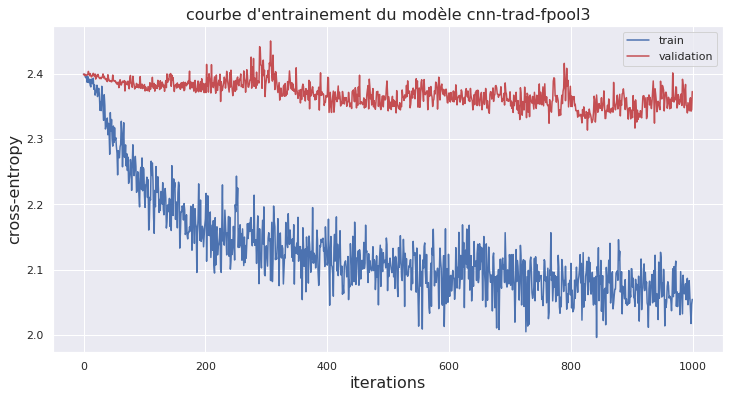

In [84]:
sns.set()

plt.figure(figsize=(12,6))

plt.title("courbe d'entrainement du modèle cnn-trad-fpool3",fontsize=16)
plt.xlabel("iterations",fontsize=16)
plt.ylabel("cross-entropy",fontsize=16)

plt.plot(np.arange(itera + 1),train_loss,'b',label='train')
plt.plot(np.arange(itera + 1),valid_loss,'r',label="validation")
plt.legend()
plt.show()

## _cnn-one-fpool3_

In [85]:
class Cnnonefpool3(torch.nn.Module):
    
    
    def __init__(self):
        super(Cnnonefpool3, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(1, 54, kernel_size=(32,8), stride=1)
        
        self.conv1_bn = torch.nn.BatchNorm2d(54)
        
        self.pool = torch.nn.MaxPool2d(kernel_size=(1,3))
                
        self.dropout = torch.nn.Dropout(0.5)
        
        self.fc1 = torch.nn.Linear(70*11*54, 32)
        
        self.fc2 = torch.nn.Linear(32, 128)
        
        self.fc3 = torch.nn.Linear(128, 128)
        
        self.fc4 = torch.nn.Linear(128, 11)
        
        self.output = torch.nn.Softmax(1)
        
    def forward(self, x):
        
        x = F.relu(self.conv1_bn(self.conv1(x)))
    
        x = self.dropout(x)
        
        x = self.pool(x)
    
        x = self.dropout(x)
            
        x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
        
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.dropout(x)
        x = self.fc3(x)
        
        x = self.output(x)
        
        return x

In [86]:
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)
X_val, y_val = shuffle(X_val, y_val)


model = Cnnonefpool3()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_func = torch.nn.CrossEntropyLoss()

data = (X_train,y_train,X_val, y_val)
model, train_loss, valid_loss, itera = train(data, model.cuda(), optimizer, loss_func,"cnn-one-fpool3.pt",1000, 256, 1000)

ypred = []

model.eval()
i = 0
batch_size = 8

with torch.no_grad():
    
    for e in range(int(X_test.shape[0]/batch_size)+1):
        ypred.append(get_model.forward(Variable(torch.FloatTensor(X_test[i:i+batch_size])).cuda()))
        i+=batch_size
        
pred = torch.stack([p for pred in ypred for p in pred])
pred.shape, y_test.shape

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration

iteration 594
iteration 595
iteration 596
iteration 597
iteration 598
iteration 599
iteration 600
iteration 601
iteration 602
iteration 603
iteration 604
iteration 605
iteration 606
iteration 607
iteration 608
iteration 609
iteration 610
iteration 611
iteration 612
iteration 613
iteration 614
iteration 615
iteration 616
iteration 617
iteration 618
iteration 619
iteration 620
iteration 621
iteration 622
iteration 623
iteration 624
iteration 625
iteration 626
iteration 627
iteration 628
iteration 629
iteration 630
iteration 631
iteration 632
iteration 633
iteration 634
iteration 635
iteration 636
iteration 637
iteration 638
iteration 639
iteration 640
iteration 641
iteration 642
iteration 643
iteration 644
iteration 645
iteration 646
iteration 647
iteration 648
iteration 649
iteration 650
iteration 651
iteration 652
iteration 653
iteration 654
iteration 655
iteration 656
iteration 657
iteration 658
iteration 659
iteration 660
iteration 661
iteration 662
iteration 663
iteration 664
iterat

(torch.Size([4607, 11]), (4607,))

In [87]:
print("auc roc score %s"%roc_auc_score(pd.get_dummies(y_test), pred.data, average="macro"))

auc roc score 0.6896764586102069


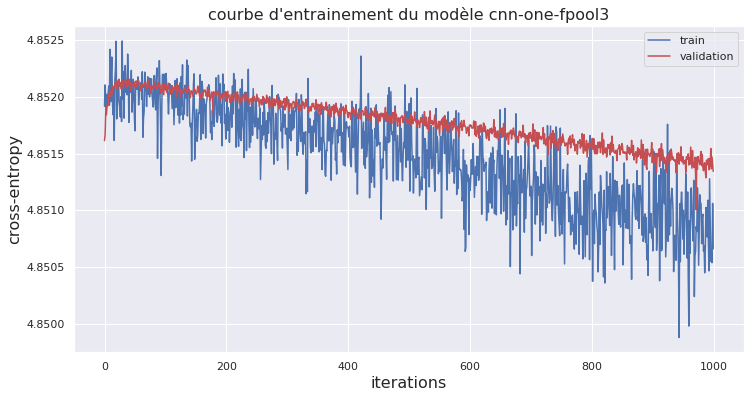

In [88]:
sns.set()

plt.figure(figsize=(12,6))

plt.title("courbe d'entrainement du modèle cnn-one-fpool3",fontsize=16)
plt.xlabel("iterations",fontsize=16)
plt.ylabel("cross-entropy",fontsize=16)

plt.plot(np.arange(itera + 1),train_loss,'b',label='train')
plt.plot(np.arange(itera + 1),valid_loss,'r',label="validation")
plt.legend()
plt.show()

## _cnn-tpool3_

In [89]:
class Cnntpool3(torch.nn.Module):
    
    
    def __init__(self):
        super(Cnntpool3, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(1, 94, kernel_size=(21,8), stride=1)
        
        self.conv1_bn = torch.nn.BatchNorm2d(94)
        
        self.pool = torch.nn.MaxPool2d(kernel_size=(3,3))
          
        self.conv2 = torch.nn.Conv2d(94, 94, kernel_size=(6,4), stride=1)
        
        self.dropout = torch.nn.Dropout(0.5)
        
        self.fc1 = torch.nn.Linear(8*22*94, 32)
        
        self.fc2 = torch.nn.Linear(32, 128)
        
        self.fc3 = torch.nn.Linear(128, 128)
        
        self.fc4 = torch.nn.Linear(128, 11)
        
        self.output = torch.nn.Softmax(1)
        
    def forward(self, x):
        
        x = F.relu(self.conv1_bn(self.conv1(x)))
    
        x = self.dropout(x)
        
        x = self.pool(x)
    
        x = self.dropout(x)
        
        x = F.relu(self.conv1_bn(self.conv2(x)))
        
        x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
        
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.dropout(x)
        x = self.fc3(x)
        
        x = self.output(x)
        
        return x

In [90]:
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)
X_val, y_val = shuffle(X_val, y_val)


model = Cnntpool3()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_func = torch.nn.CrossEntropyLoss()

data = (X_train,y_train,X_val, y_val)
model, train_loss, valid_loss, itera = train(data, model.cuda(), optimizer, loss_func,"cnn-tpool3.pt",100, 256, 1000)

ypred = []

model.eval()
i = 0
batch_size = 8

with torch.no_grad():
    
    for e in range(int(X_test.shape[0]/batch_size)+1):
        ypred.append(get_model.forward(Variable(torch.FloatTensor(X_test[i:i+batch_size])).cuda()))
        i+=batch_size
        
pred = torch.stack([p for pred in ypred for p in pred])
pred.shape, y_test.shape

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration

(torch.Size([4607, 11]), (4607,))

In [91]:
print("auc roc score %s"%roc_auc_score(pd.get_dummies(y_test), pred.data, average="macro"))

auc roc score 0.6896765639422079


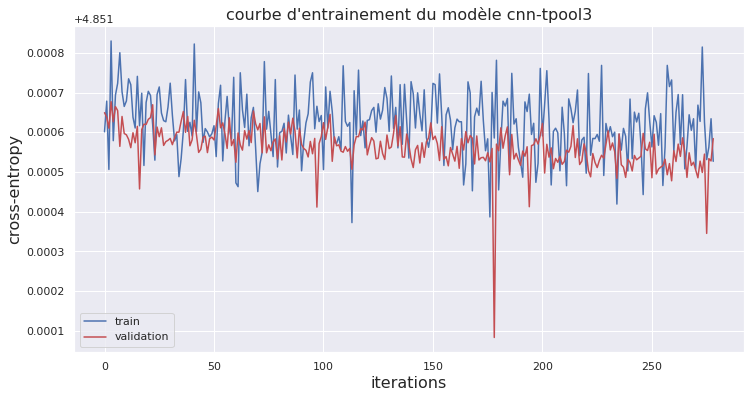

In [92]:
sns.set()

plt.figure(figsize=(12,6))

plt.title("courbe d'entrainement du modèle cnn-tpool3",fontsize=16)
plt.xlabel("iterations",fontsize=16)
plt.ylabel("cross-entropy",fontsize=16)

plt.plot(np.arange(itera + 1),train_loss,'b',label='train')
plt.plot(np.arange(itera + 1),valid_loss,'r',label="validation")
plt.legend()
plt.show()

## _baseline with desicion tree_

In [95]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_train.reshape(-1,101*40),y_train)

In [94]:
pred = clf.predict_proba(X_test.reshape(-1,101*40))
print("auc roc score %s"%roc_auc_score(pd.get_dummies(y_test), pred, average="macro"))

auc roc score 0.7909008888736383
